# Scaling Laws Analysis: Comparing Training Runs to OpenAI's 2020 Scaling Laws

This notebook analyzes our training runs against the compute-optimal scaling law from OpenAI's 2020 paper:
**"Scaling Laws for Neural Language Models"** (Kaplan et al., 2020)

## The Scaling Law

OpenAI found that the optimal test loss follows a power law with compute:

$$L = \left(\frac{C_{min}}{2.3 \times 10^8}\right)^{-0.050}$$

Where:
- $L$ is the test loss (cross-entropy in nats)
- $C_{min}$ is the compute in **PF-days** (petaflop-days, non-embedding)
- The exponent -0.050 indicates the power law relationship

## What are PF-days?

A **petaflop-day** is a unit of compute:
- 1 PF-day = $10^{15}$ FLOPS × 86,400 seconds = $8.64 \times 10^{19}$ floating point operations

## Compute Estimation

For transformer training, the compute is approximately:

$$C \approx 6 \times N \times D$$

Where:
- $N$ = number of non-embedding parameters
- $D$ = number of tokens processed
- Factor of 6 accounts for forward pass (2N per token) + backward pass (4N per token)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
import warnings
warnings.filterwarnings('ignore')

# Set up nice plotting defaults
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

## 1. Load the Training Data

First, let's load our WandB export data containing the training loss curves.

In [2]:
# Load the CSV data
df = pd.read_csv('wandb_export_2026-01-14T17_40_30.323-08_00.csv')

# Display basic info
print(f"Total rows: {len(df)}")
print(f"\nColumns:")
for col in df.columns:
    if 'MIN' not in col and 'MAX' not in col:
        print(f"  - {col}")

Total rows: 3199

Columns:
  - Step
  - saturate_moe1Bsparse_15B - train/CE loss
  - saturate_moe1Bolmo_15B - train/CE loss
  - saturate_135M_15B_03 - train/CE loss
  - saturate_1B_15B.py - train/CE loss
  - saturate_271M_15_2_cont - train/CE loss
  - saturate_271M_15B_2 - train/CE loss


In [3]:
# Extract just the main loss columns (not MIN/MAX variants)
loss_columns = [col for col in df.columns if 'train/CE loss' in col and '__MIN' not in col and '__MAX' not in col]

print("Training runs found:")
for col in loss_columns:
    run_name = col.split(' - ')[0]
    non_null = df[col].notna().sum()
    print(f"  {run_name}: {non_null} data points")

Training runs found:
  saturate_moe1Bsparse_15B: 34 data points
  saturate_moe1Bolmo_15B: 44 data points
  saturate_135M_15B_03: 2849 data points
  saturate_1B_15B.py: 344 data points
  saturate_271M_15_2_cont: 2688 data points
  saturate_271M_15B_2: 511 data points


## 2. Define Model Configurations

We need to specify the parameters for each model to calculate compute. Based on the run names, we can infer:

| Run | Parameters | Training Tokens | Notes |
|-----|------------|-----------------|-------|
| saturate_135M_15B_03 | 135M | 15B | Small model, long training |
| saturate_271M_15B_2 | 271M | 15B | Medium model (steps 1-511) |
| saturate_271M_15_2_cont | 271M | 15B | **Continuation** (steps 512-3199) |
| saturate_1B_15B.py | 1B | 15B | Large model |
| saturate_moe1Bsparse_15B | ~1B (sparse) | 15B | MoE model |
| saturate_moe1Bolmo_15B | ~1B (sparse) | 15B | MoE model (OLMo-based) |

**Important Notes:**
1. For non-embedding parameters, we exclude the embedding layer. We assume ~90% of parameters are non-embedding.
2. **The 271M and 271M_cont runs are one continuous training run** - the CSV already has sequential step numbers (271M ends at 511, cont starts at 512), so they should line up perfectly on the X-axis.

In [4]:
# Model configurations
# Format: (total_params, non_embedding_fraction, total_tokens_target, batch_size, seq_len)
# Note: Adjust these values based on your actual configurations!

MODEL_CONFIGS = {
    'saturate_135M_15B_03': {
        'total_params': 135e6,
        'non_embedding_fraction': 0.90,  # ~90% non-embedding
        'total_tokens': 15e9,
        'batch_size': 2048,  # tokens per step (batch_size * seq_len)
        'seq_len': 2048,
        'color': '#1f77b4',
        'label': '135M'
    },
    'saturate_271M_15B_2': {
        'total_params': 271e6,
        'non_embedding_fraction': 0.90,
        'total_tokens': 15e9,
        'batch_size': 2048,
        'seq_len': 2048,
        'color': '#ff7f0e',
        'label': '271M'
    },
    'saturate_1B_15B.py': {
        'total_params': 1e9,
        'non_embedding_fraction': 0.92,  # Larger models have smaller embedding fraction
        'total_tokens': 15e9,
        'batch_size': 2048,
        'seq_len': 2048,
        'color': '#2ca02c',
        'label': '1B'
    },
    'saturate_271M_15_2_cont': {
        # This is a CONTINUATION of saturate_271M_15B_2
        # The CSV already has continuous step numbers (512+), so no offset needed
        'total_params': 271e6,
        'non_embedding_fraction': 0.90,
        'total_tokens': 15e9,
        'batch_size': 2048,
        'seq_len': 2048,
        'color': '#ff7f0e',  # Same color as 271M to show continuity
        'label': '271M (cont)',
        'linestyle': '-'  # Solid line to distinguish from dashed
    },
    'saturate_moe1Bsparse_15B': {
        'total_params': 1e9,
        'non_embedding_fraction': 0.90,
        'active_params_fraction': 0.25,  # MoE: only ~25% active per token
        'total_tokens': 15e9,
        'batch_size': 2048,
        'seq_len': 2048,
        'color': '#9467bd',
        'label': 'MoE-1B (sparse)',
        'is_moe': True
    },
    'saturate_moe1Bolmo_15B': {
        'total_params': 1e9,
        'non_embedding_fraction': 0.90,
        'active_params_fraction': 0.25,
        'total_tokens': 15e9,
        'batch_size': 2048,
        'seq_len': 2048,
        'color': '#8c564b',
        'label': 'MoE-1B (OLMo)',
        'is_moe': True
    }
}

print("Model configurations loaded.")
print("\n⚠️  IMPORTANT: Please verify these parameters match your actual training configs!")
print("   Especially: batch_size, seq_len, and total_params")
print("\n📝 Note: 271M and 271M (cont) share the same color since they're one continuous run.")

Model configurations loaded.

⚠️  IMPORTANT: Please verify these parameters match your actual training configs!
   Especially: batch_size, seq_len, and total_params

📝 Note: 271M and 271M (cont) share the same color since they're one continuous run.


## 3. Calculate Compute in PF-days

Now we'll convert training steps to compute (PF-days) using the formula:

$$C_{\text{PF-days}} = \frac{6 \times N_{\text{non-emb}} \times D}{8.64 \times 10^{19}}$$

Where:
- $D$ = tokens processed = step × batch_size × seq_len
- $N_{\text{non-emb}}$ = non-embedding parameters

For **MoE models**, we use the **active parameters** (not total) since only a fraction of experts are used per token.

In [5]:
# Constants
FLOPS_PER_PF_DAY = 8.64e19  # 10^15 * 86400

def calculate_compute_pf_days(step, config):
    """
    Calculate compute in PF-days for a given training step.
    
    For dense models: C = 6 * N * D
    For MoE models: C = 6 * N_active * D (using active parameters)
    
    Note: Step numbers in the CSV are already in the global frame
    (continuation runs start at step 512, not step 1), so no offset needed.
    """
    # Tokens processed = step * tokens_per_step
    tokens_per_step = config['batch_size'] * config['seq_len']
    total_tokens = step * tokens_per_step
    
    # Non-embedding parameters
    non_emb_params = config['total_params'] * config['non_embedding_fraction']
    
    # For MoE, use active parameters (only a fraction of experts active per token)
    if config.get('is_moe', False):
        active_params = non_emb_params * config.get('active_params_fraction', 0.25)
    else:
        active_params = non_emb_params
    
    # Compute: 6 * N * D (forward + backward)
    total_flops = 6 * active_params * total_tokens
    
    # Convert to PF-days
    pf_days = total_flops / FLOPS_PER_PF_DAY
    
    return pf_days

# Test the calculation
test_config = MODEL_CONFIGS['saturate_135M_15B_03']
test_pf_days = calculate_compute_pf_days(1000, test_config)
print(f"Test: 135M model at step 1000 = {test_pf_days:.6f} PF-days")

# Verify continuity: 271M at step 511 should be close to 271M_cont at step 512
config_271M = MODEL_CONFIGS['saturate_271M_15B_2']
pf_511 = calculate_compute_pf_days(511, config_271M)
pf_512 = calculate_compute_pf_days(512, config_271M)
print(f"\nContinuity check:")
print(f"  271M at step 511: {pf_511:.6f} PF-days")
print(f"  271M at step 512: {pf_512:.6f} PF-days")
print(f"  Gap: {(pf_512 - pf_511):.6f} PF-days (should be ~1 step worth)")

Test: 135M model at step 1000 = 0.035389 PF-days

Continuity check:
  271M at step 511: 0.036302 PF-days
  271M at step 512: 0.036373 PF-days
  Gap: 0.000071 PF-days (should be ~1 step worth)


## 4. Define OpenAI's Scaling Law

The compute-optimal frontier from the paper:

$$L = \left(\frac{C}{2.3 \times 10^8}\right)^{-0.050}$$

This represents the **best achievable loss** for a given compute budget when model size and data are optimally allocated.

In [6]:
def openai_scaling_law(compute_pf_days):
    """
    OpenAI's compute-optimal scaling law.
    
    L = (C / 2.3e8)^(-0.050)
    
    Parameters:
    -----------
    compute_pf_days : float or array
        Compute in PF-days (non-embedding)
    
    Returns:
    --------
    loss : float or array
        Predicted optimal test loss
    """
    return (compute_pf_days / 2.3e8) ** (-0.050)

# Verify the formula matches the plot
print("Scaling law verification:")
print(f"  At C = 10^-9 PF-days: L = {openai_scaling_law(1e-9):.2f}")
print(f"  At C = 10^-5 PF-days: L = {openai_scaling_law(1e-5):.2f}")
print(f"  At C = 10^-1 PF-days: L = {openai_scaling_law(1e-1):.2f}")
print(f"  At C = 10^1 PF-days:  L = {openai_scaling_law(1e1):.2f}")

Scaling law verification:
  At C = 10^-9 PF-days: L = 7.38
  At C = 10^-5 PF-days: L = 4.66
  At C = 10^-1 PF-days: L = 2.94
  At C = 10^1 PF-days:  L = 2.33


## 5. Prepare Data for Plotting

Now let's convert each training run's steps to PF-days and prepare for visualization.

In [7]:
# Process each run
processed_runs = {}

for col in loss_columns:
    run_name = col.split(' - ')[0]
    
    if run_name not in MODEL_CONFIGS:
        print(f"⚠️  Skipping {run_name} - no config found")
        continue
    
    config = MODEL_CONFIGS[run_name]
    
    # Get non-null data
    mask = df[col].notna()
    steps = df.loc[mask, 'Step'].values
    losses = df.loc[mask, col].values
    
    if len(steps) == 0:
        print(f"⚠️  Skipping {run_name} - no data")
        continue
    
    # Calculate PF-days for each step
    pf_days = np.array([calculate_compute_pf_days(s, config) for s in steps])
    
    processed_runs[run_name] = {
        'steps': steps,
        'losses': losses,
        'pf_days': pf_days,
        'config': config
    }
    
    print(f"✓ {run_name}:")
    print(f"    Steps: {steps[0]} to {steps[-1]}")
    print(f"    PF-days: {pf_days[0]:.2e} to {pf_days[-1]:.2e}")
    print(f"    Loss: {losses[0]:.3f} to {losses[-1]:.3f}")

✓ saturate_moe1Bsparse_15B:
    Steps: 1 to 34
    PF-days: 6.55e-05 to 2.23e-03
    Loss: 10.983 to 7.757
✓ saturate_moe1Bolmo_15B:
    Steps: 1 to 44
    PF-days: 6.55e-05 to 2.88e-03
    Loss: 11.046 to 6.787
✓ saturate_135M_15B_03:
    Steps: 1 to 2849
    PF-days: 3.54e-05 to 1.01e-01
    Loss: 10.993 to 3.451
✓ saturate_1B_15B.py:
    Steps: 1 to 344
    PF-days: 2.68e-04 to 9.22e-02
    Loss: 11.220 to 4.558
✓ saturate_271M_15_2_cont:
    Steps: 512 to 3199
    PF-days: 3.64e-02 to 2.27e-01
    Loss: 4.105 to 3.266
✓ saturate_271M_15B_2:
    Steps: 1 to 511
    PF-days: 7.10e-05 to 3.63e-02
    Loss: 11.022 to 4.139


## 6. Main Comparison Plot

This is the key visualization comparing our training runs to OpenAI's scaling law.

**Interpretation:**
- Points **above** the orange line are using compute **less efficiently** than optimal
- Points **on** the orange line are at the compute-optimal frontier
- Points **below** the orange line would be better than OpenAI's fit (unlikely, may indicate measurement/config differences)

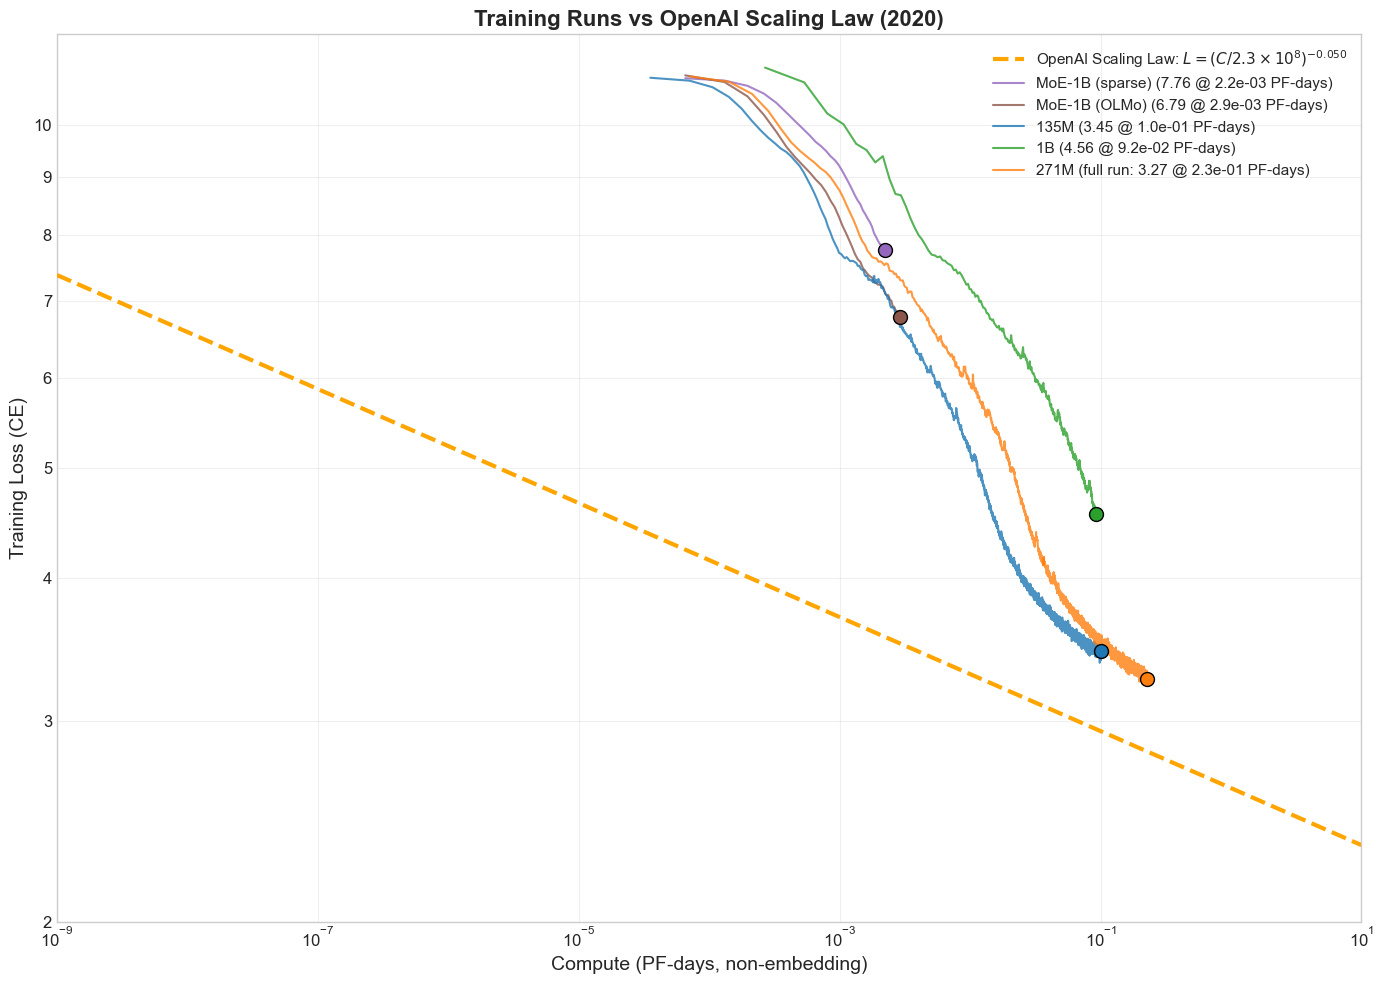


📊 Plot saved to 'scaling_law_comparison.png'


In [8]:
fig, ax = plt.subplots(figsize=(14, 10))

# Plot the OpenAI scaling law
compute_range = np.logspace(-9, 1, 1000)
scaling_law_loss = openai_scaling_law(compute_range)

ax.plot(compute_range, scaling_law_loss, '--', color='orange', linewidth=3, 
        label=r'OpenAI Scaling Law: $L = (C/2.3 \times 10^8)^{-0.050}$', zorder=10)

# Plot each training run
# Special handling: plot 271M and 271M_cont as one continuous line
for run_name, data in processed_runs.items():
    config = data['config']
    
    # Skip 271M_cont in the main loop - we'll handle it with 271M
    if run_name == 'saturate_271M_15_2_cont':
        continue
    
    # For 271M, also plot the continuation
    if run_name == 'saturate_271M_15B_2' and 'saturate_271M_15_2_cont' in processed_runs:
        cont_data = processed_runs['saturate_271M_15_2_cont']
        
        # Combine the two runs
        combined_pf_days = np.concatenate([data['pf_days'], cont_data['pf_days']])
        combined_losses = np.concatenate([data['losses'], cont_data['losses']])
        
        # Plot as one continuous line
        ax.plot(combined_pf_days, combined_losses, 
                color=config['color'], 
                linewidth=1.5,
                alpha=0.8,
                label=f"271M (full run: {cont_data['losses'][-1]:.2f} @ {cont_data['pf_days'][-1]:.1e} PF-days)")
        
        # Mark the endpoint
        ax.scatter([cont_data['pf_days'][-1]], [cont_data['losses'][-1]], 
                   color=config['color'], s=100, zorder=5, edgecolors='black', linewidth=1)
        
        # Mark the handoff point with a small marker
        ax.scatter([data['pf_days'][-1]], [data['losses'][-1]], 
                   color=config['color'], s=30, zorder=5, marker='|', linewidth=2)
    else:
        # Regular plotting for other runs
        ax.plot(data['pf_days'], data['losses'], 
                color=config['color'], 
                linewidth=1.5,
                alpha=0.8,
                label=f"{config['label']} ({data['losses'][-1]:.2f} @ {data['pf_days'][-1]:.1e} PF-days)")
        
        # Mark the endpoint
        ax.scatter([data['pf_days'][-1]], [data['losses'][-1]], 
                   color=config['color'], s=100, zorder=5, edgecolors='black', linewidth=1)

# Formatting
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Compute (PF-days, non-embedding)', fontsize=14)
ax.set_ylabel('Training Loss (CE)', fontsize=14)
ax.set_title('Training Runs vs OpenAI Scaling Law (2020)', fontsize=16, fontweight='bold')

# Set axis limits similar to OpenAI plot
ax.set_xlim(1e-9, 1e1)
ax.set_ylim(2, 12)

# Custom y-ticks to match OpenAI plot
ax.set_yticks([2, 3, 4, 5, 6, 7, 8, 9, 10])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())

ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('scaling_law_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Plot saved to 'scaling_law_comparison.png'")

## 7. Efficiency Analysis

Let's quantify how our models compare to the optimal frontier.

We'll compute the **efficiency ratio**: how much more compute we're using compared to the optimal frontier to achieve the same loss.

$$\text{Efficiency} = \frac{C_{\text{optimal}}(L)}{C_{\text{actual}}}$$

Where $C_{\text{optimal}}(L)$ is the compute needed to achieve loss $L$ on the optimal frontier.

In [9]:
def compute_for_loss(target_loss):
    """
    Invert the scaling law to find compute needed for a target loss.
    
    From: L = (C / 2.3e8)^(-0.050)
    We get: C = 2.3e8 * L^(-1/0.050) = 2.3e8 * L^(-20)
    """
    return 2.3e8 * (target_loss ** (-20))

print("="*70)
print("EFFICIENCY ANALYSIS")
print("="*70)
print(f"{'Run':<30} {'Final Loss':<12} {'Actual C':<15} {'Optimal C':<15} {'Efficiency':<10}")
print("-"*70)

efficiency_data = []

for run_name, data in processed_runs.items():
    # Skip the continuation - it's included in the 271M analysis
    if run_name == 'saturate_271M_15_2_cont':
        continue
        
    # For 271M, use the continuation's final values
    if run_name == 'saturate_271M_15B_2' and 'saturate_271M_15_2_cont' in processed_runs:
        cont_data = processed_runs['saturate_271M_15_2_cont']
        final_loss = cont_data['losses'][-1]
        actual_compute = cont_data['pf_days'][-1]
        label = '271M (full run)'
    else:
        final_loss = data['losses'][-1]
        actual_compute = data['pf_days'][-1]
        label = data['config']['label']
    
    optimal_compute = compute_for_loss(final_loss)
    efficiency = optimal_compute / actual_compute
    
    efficiency_data.append({
        'run': run_name,
        'label': label,
        'final_loss': final_loss,
        'actual_compute': actual_compute,
        'optimal_compute': optimal_compute,
        'efficiency': efficiency
    })
    
    print(f"{label:<30} {final_loss:<12.3f} {actual_compute:<15.2e} {optimal_compute:<15.2e} {efficiency:<10.1%}")

print("\n📝 Interpretation:")
print("   - Efficiency > 100%: Performing BETTER than OpenAI's frontier (or config mismatch)")
print("   - Efficiency ≈ 100%: On par with compute-optimal frontier")
print("   - Efficiency < 100%: Using more compute than optimal for this loss")

EFFICIENCY ANALYSIS
Run                            Final Loss   Actual C        Optimal C       Efficiency
----------------------------------------------------------------------
MoE-1B (sparse)                7.757        2.23e-03        3.70e-10        0.0%      
MoE-1B (OLMo)                  6.787        2.88e-03        5.35e-09        0.0%      
135M                           3.451        1.01e-01        4.00e-03        4.0%      
1B                             4.558        9.22e-02        1.53e-05        0.0%      
271M (full run)                3.266        2.27e-01        1.20e-02        5.3%      

📝 Interpretation:
   - Efficiency > 100%: Performing BETTER than OpenAI's frontier (or config mismatch)
   - Efficiency ≈ 100%: On par with compute-optimal frontier
   - Efficiency < 100%: Using more compute than optimal for this loss


## 8. Efficiency Over Training

How does efficiency change during training? Early in training, loss drops quickly (high efficiency). As training progresses, diminishing returns set in.

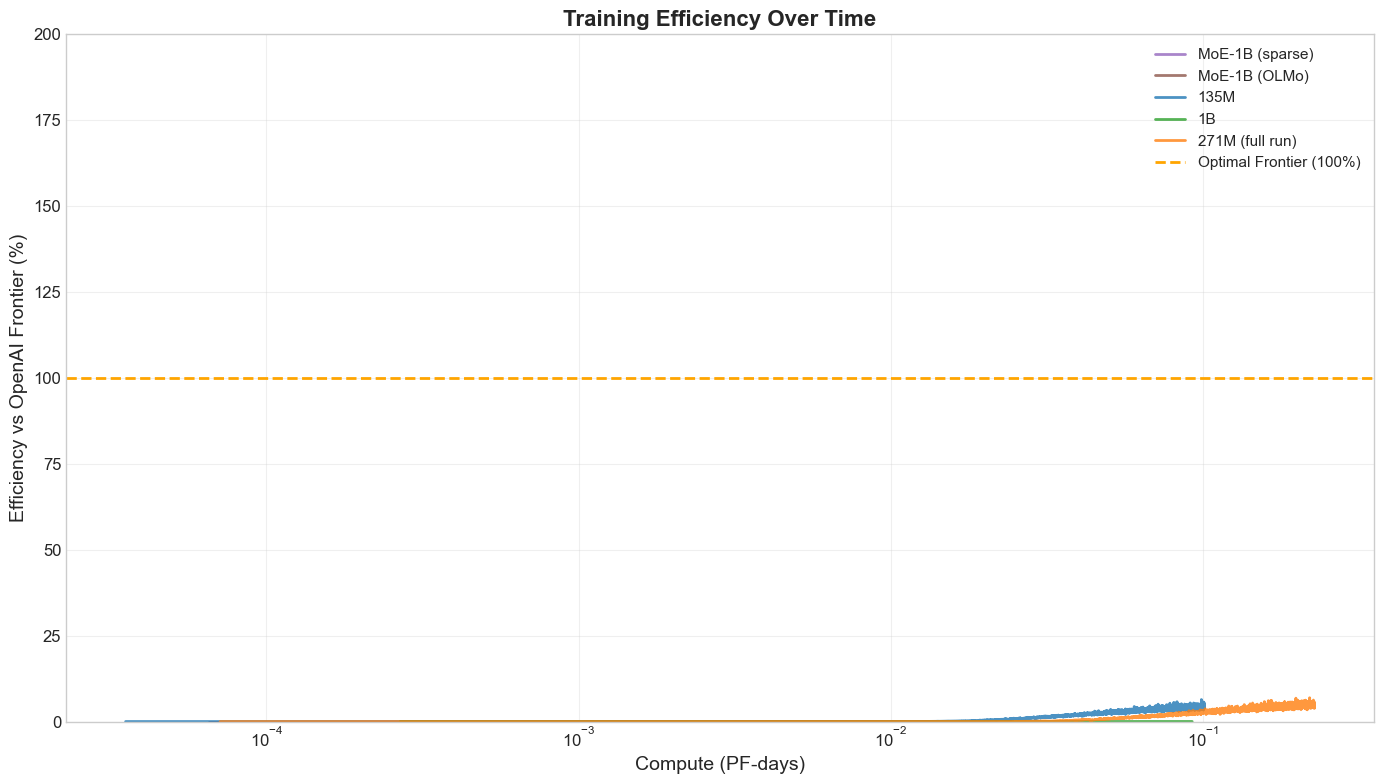

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))

for run_name, data in processed_runs.items():
    config = data['config']
    
    # Skip continuation - handled with 271M
    if run_name == 'saturate_271M_15_2_cont':
        continue
    
    # For 271M, combine with continuation
    if run_name == 'saturate_271M_15B_2' and 'saturate_271M_15_2_cont' in processed_runs:
        cont_data = processed_runs['saturate_271M_15_2_cont']
        combined_pf_days = np.concatenate([data['pf_days'], cont_data['pf_days']])
        combined_losses = np.concatenate([data['losses'], cont_data['losses']])
        
        optimal_computes = np.array([compute_for_loss(l) for l in combined_losses])
        efficiencies = optimal_computes / combined_pf_days * 100
        
        ax.plot(combined_pf_days, efficiencies,
                color=config['color'],
                linewidth=2,
                alpha=0.8,
                label='271M (full run)')
    else:
        # Calculate efficiency at each point
        optimal_computes = np.array([compute_for_loss(l) for l in data['losses']])
        efficiencies = optimal_computes / data['pf_days'] * 100  # as percentage
        
        ax.plot(data['pf_days'], efficiencies,
                color=config['color'],
                linewidth=2,
                alpha=0.8,
                label=config['label'])

# Add reference line at 100%
ax.axhline(y=100, color='orange', linestyle='--', linewidth=2, label='Optimal Frontier (100%)')

ax.set_xscale('log')
ax.set_xlabel('Compute (PF-days)', fontsize=14)
ax.set_ylabel('Efficiency vs OpenAI Frontier (%)', fontsize=14)
ax.set_title('Training Efficiency Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 200)

plt.tight_layout()
plt.savefig('efficiency_over_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Loss vs Predicted Loss (Log-Linear Scale)

Compare actual loss to what the scaling law predicts for our compute. This version uses log scale on X-axis (compute) and linear scale on Y-axis (loss).

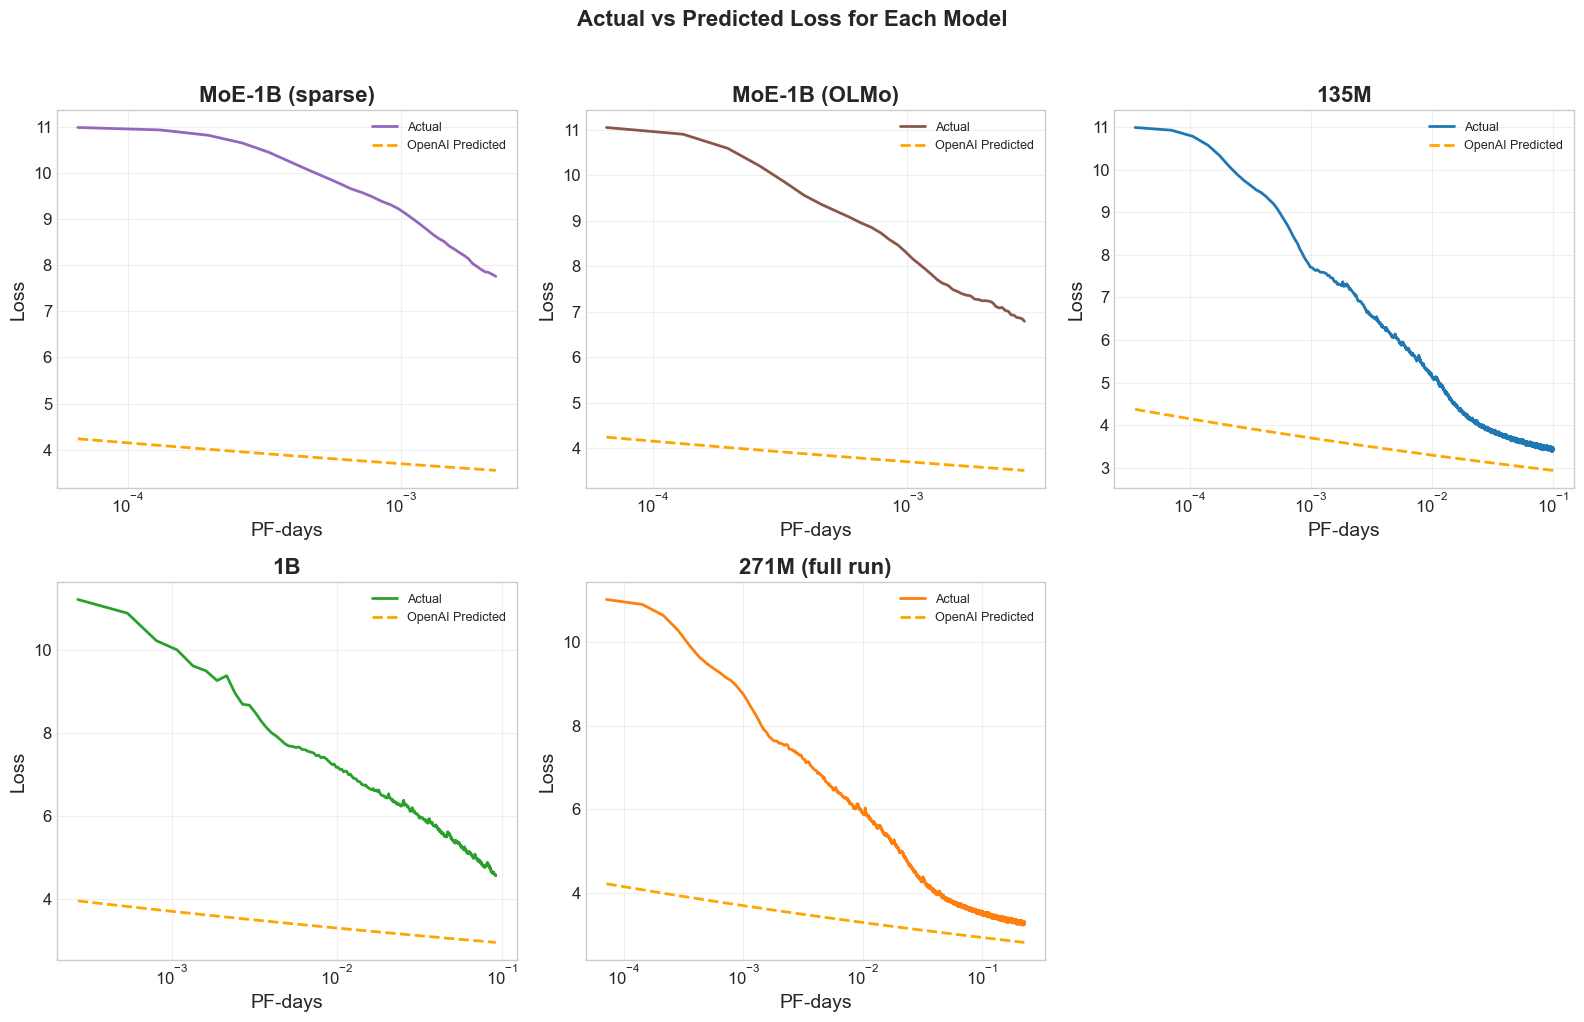

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Create a filtered list that combines 271M runs
plot_runs = []
for run_name, data in processed_runs.items():
    if run_name == 'saturate_271M_15_2_cont':
        continue  # Skip - combined with 271M
    
    if run_name == 'saturate_271M_15B_2' and 'saturate_271M_15_2_cont' in processed_runs:
        cont_data = processed_runs['saturate_271M_15_2_cont']
        combined = {
            'pf_days': np.concatenate([data['pf_days'], cont_data['pf_days']]),
            'losses': np.concatenate([data['losses'], cont_data['losses']]),
            'config': {**data['config'], 'label': '271M (full run)'}
        }
        plot_runs.append(('271M_combined', combined))
    else:
        plot_runs.append((run_name, data))

for idx, (run_name, data) in enumerate(plot_runs):
    if idx >= 6:
        break
        
    ax = axes[idx]
    config = data['config']
    
    # Predicted loss from scaling law
    predicted_loss = openai_scaling_law(data['pf_days'])
    
    ax.plot(data['pf_days'], data['losses'], 
            color=config['color'], linewidth=2, label='Actual')
    ax.plot(data['pf_days'], predicted_loss, 
            '--', color='orange', linewidth=2, label='OpenAI Predicted')
    
    ax.set_xscale('log')
    ax.set_xlabel('PF-days')
    ax.set_ylabel('Loss')
    ax.set_title(config['label'], fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(plot_runs), 6):
    axes[idx].set_visible(False)

plt.suptitle('Actual vs Predicted Loss for Each Model', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

### 9a. Actual vs Predicted Loss (Linear-Linear Scale)

Same comparison but with linear scales on both axes. This view emphasizes the absolute differences at higher compute values.

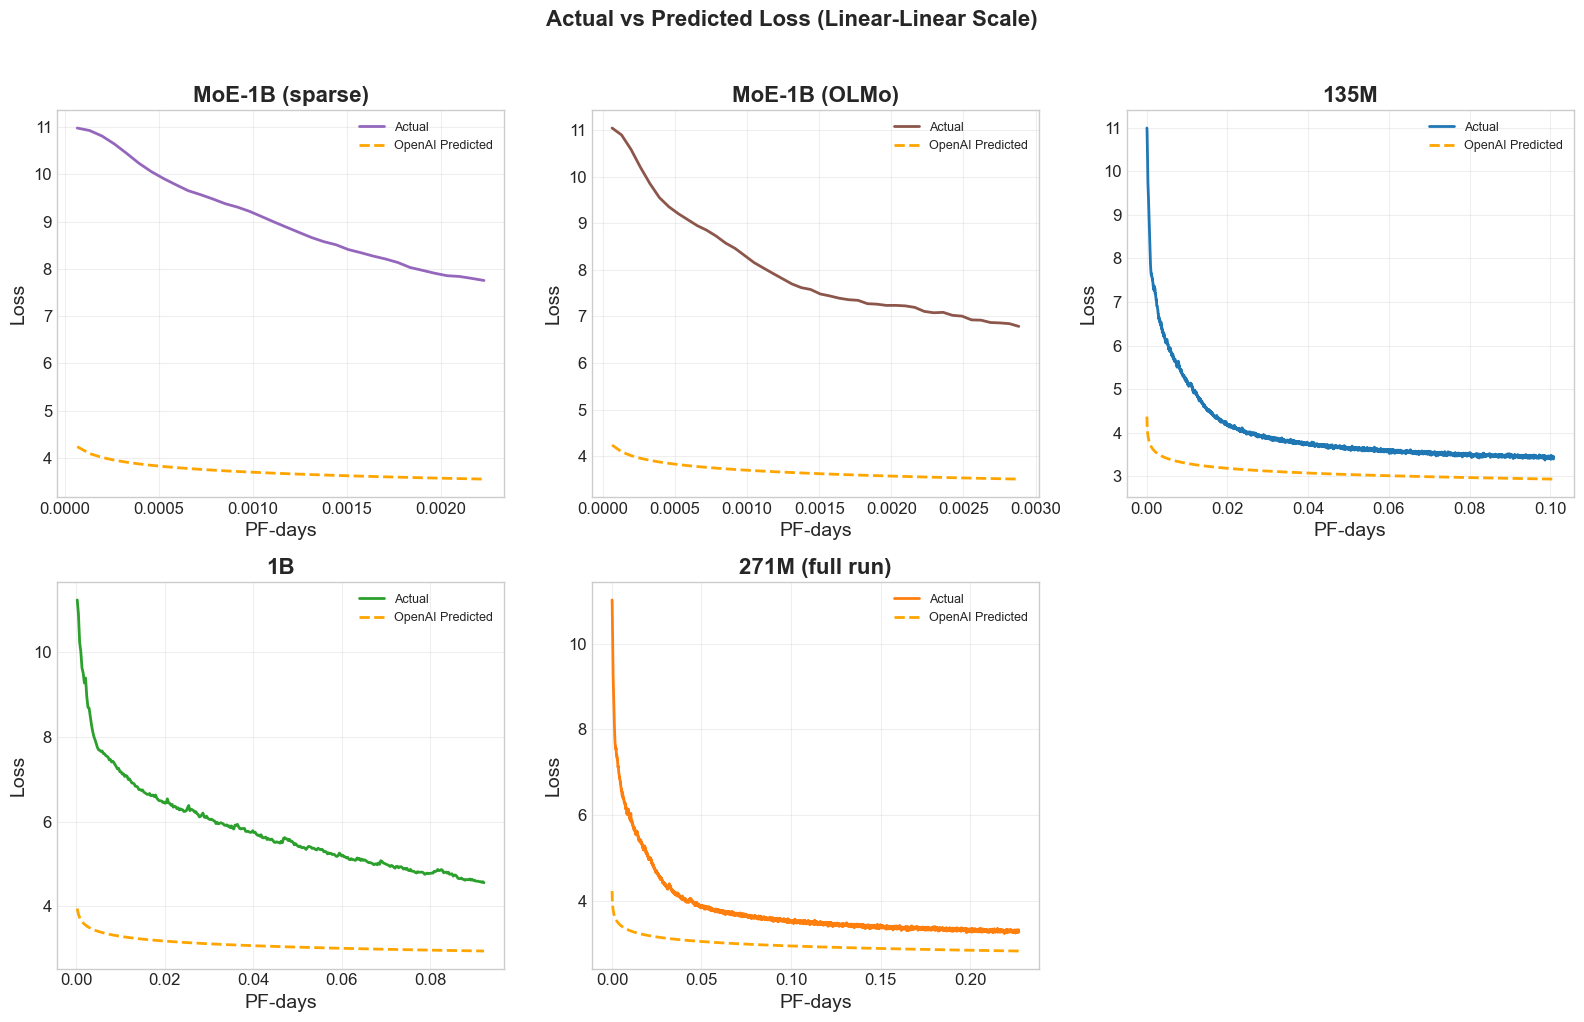

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (run_name, data) in enumerate(plot_runs):
    if idx >= 6:
        break
        
    ax = axes[idx]
    config = data['config']
    
    # Predicted loss from scaling law
    predicted_loss = openai_scaling_law(data['pf_days'])
    
    ax.plot(data['pf_days'], data['losses'], 
            color=config['color'], linewidth=2, label='Actual')
    ax.plot(data['pf_days'], predicted_loss, 
            '--', color='orange', linewidth=2, label='OpenAI Predicted')
    
    # LINEAR-LINEAR scales
    ax.set_xlabel('PF-days')
    ax.set_ylabel('Loss')
    ax.set_title(config['label'], fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(plot_runs), 6):
    axes[idx].set_visible(False)

plt.suptitle('Actual vs Predicted Loss (Linear-Linear Scale)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('actual_vs_predicted_linear.png', dpi=150, bbox_inches='tight')
plt.show()

### 9b. Actual vs Predicted Loss (Log-Log Scale)

Log-log scales on both axes. This is the standard view for power law relationships - a power law appears as a straight line in log-log space.

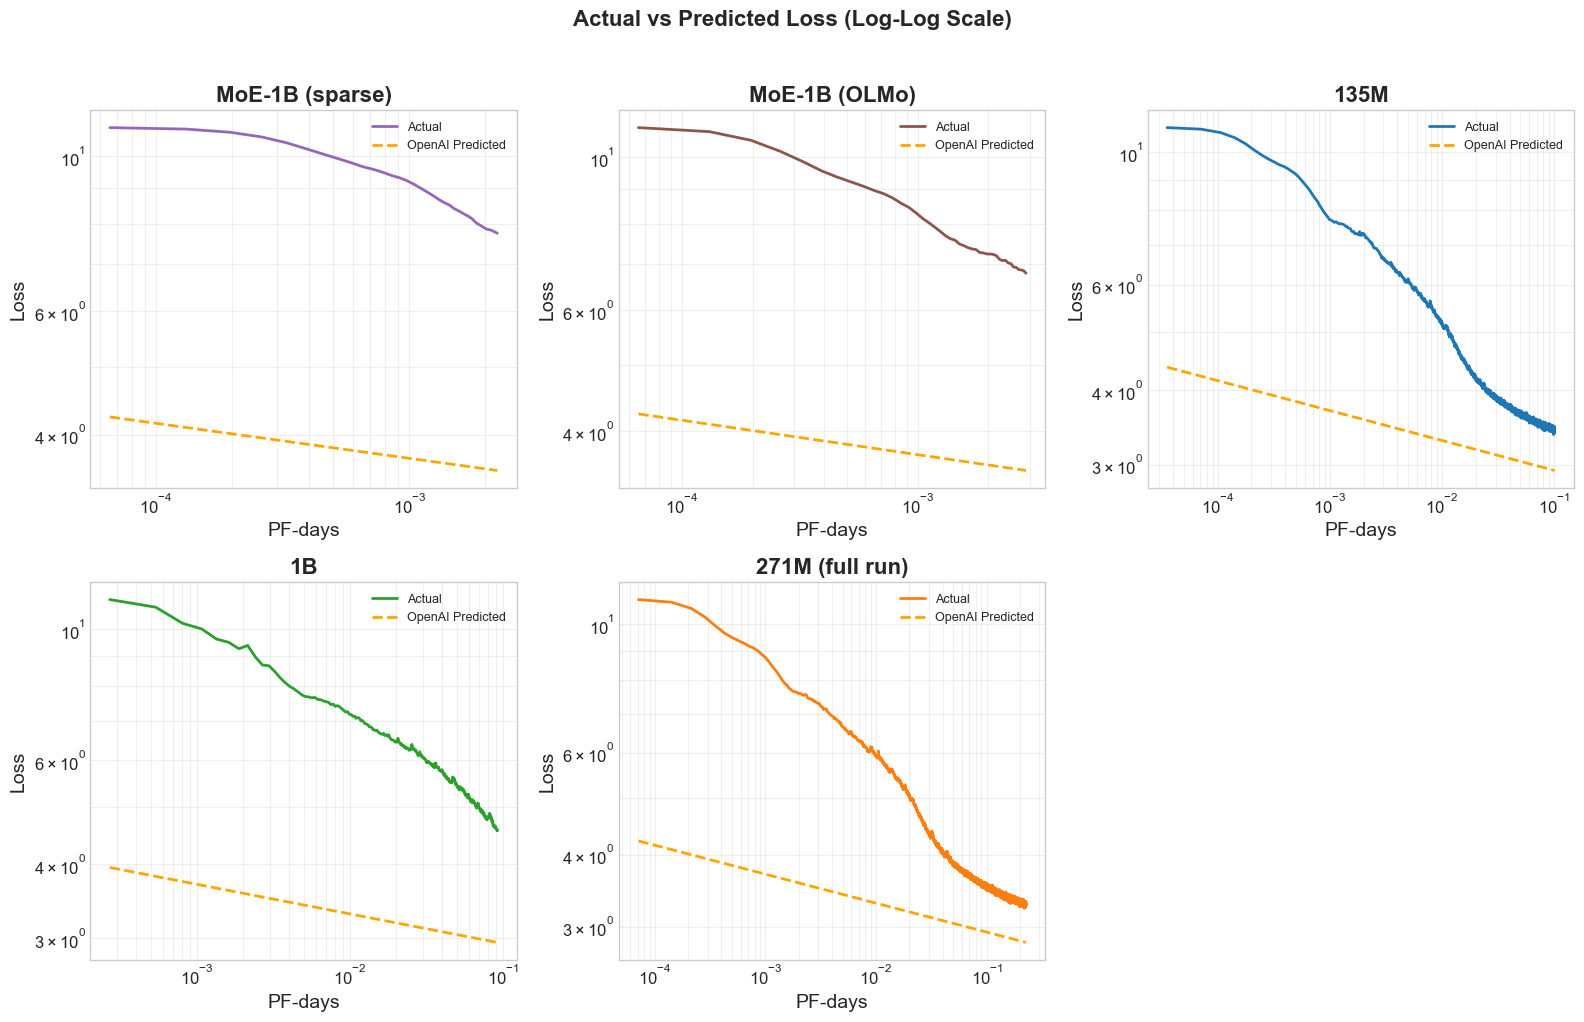

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (run_name, data) in enumerate(plot_runs):
    if idx >= 6:
        break
        
    ax = axes[idx]
    config = data['config']
    
    # Predicted loss from scaling law
    predicted_loss = openai_scaling_law(data['pf_days'])
    
    ax.plot(data['pf_days'], data['losses'], 
            color=config['color'], linewidth=2, label='Actual')
    ax.plot(data['pf_days'], predicted_loss, 
            '--', color='orange', linewidth=2, label='OpenAI Predicted')
    
    # LOG-LOG scales
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('PF-days')
    ax.set_ylabel('Loss')
    ax.set_title(config['label'], fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, which='both')

# Hide unused subplots
for idx in range(len(plot_runs), 6):
    axes[idx].set_visible(False)

plt.suptitle('Actual vs Predicted Loss (Log-Log Scale)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('actual_vs_predicted_loglog.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Summary and Discussion

### Key Findings

In [14]:
print("="*70)
print("SUMMARY")
print("="*70)

# Sort by final loss
sorted_runs = sorted(efficiency_data, key=lambda x: x['final_loss'])

print("\n📊 Runs ranked by final loss (best to worst):")
print()
for i, run in enumerate(sorted_runs, 1):
    status = "✓ On frontier" if 0.8 <= run['efficiency'] <= 1.2 else "⚠️ Off frontier"
    print(f"  {i}. {run['label']:<20} Loss: {run['final_loss']:.3f}  Efficiency: {run['efficiency']:.0%}  {status}")

print("\n" + "="*70)
print("INTERPRETATION GUIDE")
print("="*70)
print("""
The OpenAI scaling law represents the OPTIMAL frontier - the best loss achievable
for a given compute budget when model size and training data are perfectly balanced.

If your runs are ABOVE the orange line (efficiency < 100%):
  → You're using more compute than optimal for the achieved loss
  → Possible causes:
    • Model is too large for the data (undertrained)
    • Model is too small for the data (overtrained/saturated)
    • Suboptimal hyperparameters (learning rate, batch size)
    • Different tokenizer/vocabulary
    • Different data distribution

If your runs are ON the orange line (efficiency ≈ 100%):
  → Congratulations! You're achieving compute-optimal training

If your runs are BELOW the orange line (efficiency > 100%):
  → Either your setup is somehow more efficient, OR
  → The compute calculation parameters need adjustment
  → Check: batch_size, seq_len, param counts in MODEL_CONFIGS

⚠️  Note: The original OpenAI paper used:
  • WebText dataset
  • Specific BPE tokenizer  
  • Test loss (not training loss)
  
Your results may differ due to different data, tokenization, or using train vs test loss.
""")

SUMMARY

📊 Runs ranked by final loss (best to worst):

  1. 271M (full run)      Loss: 3.266  Efficiency: 5%  ⚠️ Off frontier
  2. 135M                 Loss: 3.451  Efficiency: 4%  ⚠️ Off frontier
  3. 1B                   Loss: 4.558  Efficiency: 0%  ⚠️ Off frontier
  4. MoE-1B (OLMo)        Loss: 6.787  Efficiency: 0%  ⚠️ Off frontier
  5. MoE-1B (sparse)      Loss: 7.757  Efficiency: 0%  ⚠️ Off frontier

INTERPRETATION GUIDE

The OpenAI scaling law represents the OPTIMAL frontier - the best loss achievable
for a given compute budget when model size and training data are perfectly balanced.

If your runs are ABOVE the orange line (efficiency < 100%):
  → You're using more compute than optimal for the achieved loss
  → Possible causes:
    • Model is too large for the data (undertrained)
    • Model is too small for the data (overtrained/saturated)
    • Suboptimal hyperparameters (learning rate, batch size)
    • Different tokenizer/vocabulary
    • Different data distribution

If yo

## 11. Chinchilla Comparison (Optional)

The 2022 Chinchilla paper (Hoffmann et al.) found a different optimal scaling:

$$L = \left(\frac{C}{C_0}\right)^{-\alpha}$$

With $\alpha \approx 0.34$ for the compute-efficient frontier, which suggests more aggressive scaling of data relative to model size.

Key difference:
- **OpenAI 2020**: Scale model size faster than data
- **Chinchilla 2022**: Keep model size and data more balanced (roughly equal scaling)

In [15]:
# Chinchilla-style scaling (approximate)
# Note: Chinchilla uses different parameterization, this is a rough comparison

def chinchilla_scaling(compute_pf_days, a=406.4, b=0.34):
    """
    Approximate Chinchilla scaling law.
    Uses a steeper exponent reflecting better data efficiency.
    
    Note: This is simplified - Chinchilla has a more complex 3-term formula.
    """
    # Convert to rough FLOP scale that Chinchilla used
    flops = compute_pf_days * 8.64e19
    return a * (flops ** -b) + 1.69  # 1.69 is approximate irreducible loss

# This is illustrative only - Chinchilla used different measurements
print("Note: Chinchilla comparison requires careful parameter matching.")
print("The Chinchilla paper used different compute accounting and loss measurement.")

Note: Chinchilla comparison requires careful parameter matching.
The Chinchilla paper used different compute accounting and loss measurement.


## 12. Save Results

In [16]:
# Create a summary dataframe
summary_df = pd.DataFrame(efficiency_data)
summary_df.to_csv('scaling_analysis_summary.csv', index=False)

print("Results saved:")
print("  - scaling_law_comparison.png")
print("  - efficiency_over_training.png") 
print("  - actual_vs_predicted.png (log-linear)")
print("  - actual_vs_predicted_linear.png (linear-linear)")
print("  - actual_vs_predicted_loglog.png (log-log)")
print("  - scaling_analysis_summary.csv")

summary_df

Results saved:
  - scaling_law_comparison.png
  - efficiency_over_training.png
  - actual_vs_predicted.png (log-linear)
  - actual_vs_predicted_linear.png (linear-linear)
  - actual_vs_predicted_loglog.png (log-log)
  - scaling_analysis_summary.csv


,run,label,final_loss,actual_compute,optimal_compute,efficiency
0,saturate_moe1Bsparse_15B,MoE-1B (sparse),7.756758,0.002228,3.699332e-10,1.660215e-07
1,saturate_moe1Bolmo_15B,MoE-1B (OLMo),6.787074,0.002884,5.346580e-09,1.854144e-06
2,saturate_135M_15B_03,135M,3.451272,0.100825,4.000785e-03,3.968068e-02
3,saturate_1B_15B.py,1B,4.558109,0.092181,1.534737e-05,1.664909e-04
4,saturate_271M_15B_2,271M (full run),3.266325,0.227260,1.203762e-02,5.296843e-02


---

## Appendix: Adjusting Model Configurations

If your results don't look right, you may need to adjust the `MODEL_CONFIGS` dictionary in Cell 4.

Key parameters to verify:

1. **`total_params`**: Total model parameters (check your config files)
2. **`batch_size × seq_len`**: Tokens per training step
3. **`non_embedding_fraction`**: Typically 0.85-0.95 for transformers
4. **`active_params_fraction`** (MoE only): What fraction of experts are active per token?

To find your actual values:
```python
# From your training config
batch_size = config.global_train_batch_size  
seq_len = config.model.max_sequence_length
total_params = sum(p.numel() for p in model.parameters())
```